In [1]:
# importing required libraries
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import random
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications.vgg16 import VGG16
import seaborn as sns
from sklearn import preprocessing
import joblib
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# Creating static and local variables
SIZE = 256
SEED_TRAINING = 121
SEED_TESTING = 197
SEED_VALIDATION = 164
CHANNELS =3
n_classes = 5
EPOCHS = 5
BATCH_SIZE = 16
input_shape = (SIZE, SIZE, CHANNELS)

In [3]:
#--------------------Training
def training(path) : 
    # loading data from local directory -> basic method. here labels are folder name, means each variety of data stored in particular folder.
    train_images = []       # training dataset stored here...(numpy array form of images)
    train_labels = []     # labels will be stored here 
    
    '''here we are using glob for accessing directories'''
    path = path + '\*'
    for directory_path in glob.glob(path) :   
        label = directory_path.split('\\')[-1]       # taking labels from folders
        # print(label)    # extracting label from directory path
        
        '''now we are entering into each folder and reading images from it and at a same 
        time we are also storing the label.'''
        for img_path in glob.glob(os.path.join(directory_path, '*.JPG')) :    
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)    # read color image 
            img = cv2.merge((img, img, img))      # we have grey scale image, here we are converting it into 3 channel image
            img = cv2.resize(img, (SIZE, SIZE))        # resize the image
            
            '''actually cv2 read image in BGR channel ordering, in color image we have 3 channels
            RGB so here the channel order is different nothing special!. it doesnt affect on model.
            In reality we can arrange them in any order we like.'''
            # cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            train_images.append(img)
            train_labels.append(label)
    
    # Shuffling the list to avoid the some kind of bias.
    train_data = list(zip(train_images, train_labels))
    '''Seed function is used to save the state of a random function, so that it can generate          
        same random numbers on multiple executions of the code on the same machine or on 
        different machines (for a specific seed value).'''
    random.seed(SEED_TRAINING)   
    random.shuffle(train_data)
    train_images, train_labels = zip(*train_data)   # it will unzip the ziped iterators, it will return tuple
    
    # converting tuples to numpy array.
    train_images = np.array(train_images)
    train_labels = np.array(train_labels)
    
    # let's normalize our pixel values 
    train_images = train_images / 255.0
    return train_images, train_labels

In [4]:
def testing(path) : 
    test_images = []
    test_labels = []
    
    path = path + '\*'
    for directory_path in glob.glob(path) : 
        labels = directory_path.split('\\')[-1]
        for img_path in glob.glob(os.path.join(directory_path, '*.JPG')) : 
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.merge((img, img, img)) 
            img = cv2.resize(img, (SIZE, SIZE))
            test_images.append(img)
            test_labels.append(labels)
            
    # Shuffling testing data
    test_data = list(zip(test_images, test_labels))
    random.seed(SEED_TESTING)
    random.shuffle(test_data)
    test_images, test_labels = zip(*test_data)
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)
    
    # let's normalize our pixel values
    test_images = test_images / 255.0
    return test_images, test_labels

In [5]:
# preprocessing training and testing images
X_test, y_test_labels = training(r'plant disease\train')
X_train, y_train_labels = training(r'plant disease\test')

In [6]:
# encoding labels from text to integer
le = preprocessing.LabelEncoder()
le.fit(y_train_labels)
train_label_encoded = le.transform(y_train_labels)
le.fit(y_test_labels)
test_label_encoded = le.transform(y_test_labels)

In [7]:
# extracting original labels, later we will need it.
labels = dict(zip(le.classes_,range(len(le.classes_))))
print(labels)

{'Tomato___Bacterial_spot': 0, 'Tomato___Early_blight': 1, 'Tomato___Late_blight': 2, 'Tomato___Leaf_Mold': 3, 'Tomato___healthy': 4}


In [11]:
# aliasing for better understanding
y_train, y_test = train_label_encoded, test_label_encoded

In [12]:
# let's load VGG16 Architecture without fully connected layers, considerding only fully convolutional layers
vgg_model = VGG16(weights = 'imagenet',  include_top = False, input_shape = (SIZE, SIZE,3)) 

In [13]:
# let's make all layers non-trainable
for layer in vgg_model.layers : 
    layer.trainable = False

In [14]:
# now trainable parameter will be 0 in our architecture
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [15]:
# let's extract features from convolutional network for XBG
feature_extractor = vgg_model.predict(X_train)

73/73 [==============================] - 438s 6s/step


In [16]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
X_train_features = features

In [17]:
# perform same operation on test dataset
feature_extractor_test = vgg_model.predict(X_test)
features_test = feature_extractor_test.reshape(feature_extractor_test.shape[0], -1)
X_test_features = features_test

291/291 [==============================] - 1749s 6s/step


In [18]:
# defining XGBoost Classifier model
model = xgb.XGBClassifier()
model.fit(X_train_features, y_train)
prediction = model.predict(X_test_features)

In [19]:
# inversing le transforme to get original labels
prediction = le.inverse_transform(prediction)

In [20]:
# let's check overall accuracy
print('Accuracy : ', metrics.accuracy_score(y_test_labels, prediction))

Accuracy :  0.85389505441224


<AxesSubplot:>

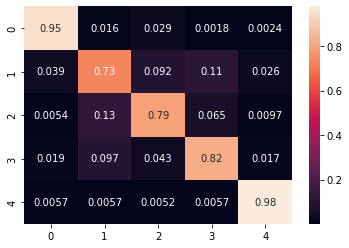

In [21]:
# Confusion Matrics : Verify accuracy of each class
cm = confusion_matrix(y_test_labels, prediction)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm, annot = True)

In [22]:
# Classification report
print(classification_report(y_test_labels, prediction))

                         precision    recall  f1-score   support

Tomato___Bacterial_spot       0.93      0.95      0.94      1702
  Tomato___Early_blight       0.75      0.73      0.74      1920
   Tomato___Late_blight       0.82      0.79      0.81      1851
     Tomato___Leaf_Mold       0.82      0.82      0.82      1882
       Tomato___healthy       0.95      0.98      0.96      1926

               accuracy                           0.85      9281
              macro avg       0.85      0.86      0.85      9281
           weighted avg       0.85      0.85      0.85      9281



In [23]:
# save the model
joblib.dump(model, 'plant_disease.pkl')

['plant_disease.pkl']